### Instalação e importação das bibliotecas utilizadas

In [5]:
!pip install -q tensorflow

In [36]:
from tensorflow.keras import datasets, models, layers
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
tf.__version__

'2.17.0'

### Separação das classes de treinamento e teste a partir do dataset mnist do tensorflow, construindo e compilando o modelo usado

In [8]:
%load_ext tensorboard

In [10]:
logdir = 'log'

In [11]:
(imagens_treinamento, labels_treinamento),(imagens_teste, labels_teste) = datasets.mnist.load_data()

imagens_treinamento = imagens_treinamento.reshape((60000,28,28,1))
imagens_teste = imagens_teste.reshape((10000,28,28,1))

imagens_treinamento = imagens_treinamento/255
imagens_teste = imagens_teste/255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10,activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [24]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(x=imagens_treinamento,
          y= labels_treinamento,
          epochs=5,
          validation_data=(imagens_teste, labels_teste))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8912 - loss: 0.3412 - val_accuracy: 0.9837 - val_loss: 0.0506
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9854 - loss: 0.0464 - val_accuracy: 0.9857 - val_loss: 0.0386
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9899 - loss: 0.0314 - val_accuracy: 0.9914 - val_loss: 0.0265
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9929 - loss: 0.0232 - val_accuracy: 0.9915 - val_loss: 0.0269
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9945 - loss: 0.0170 - val_accuracy: 0.9915 - val_loss: 0.0281


### Prevendo o y original e predito e definindo as classes

In [30]:
y_original = labels_teste
y_predito_prob = model.predict(imagens_teste)
y_predito = np.argmax(y_predito_prob, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [28]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

### Criando a matriz de confusão

In [32]:
matriz_confusao = tf.math.confusion_matrix(labels=y_original, predictions=y_predito).numpy()
matriz_confusao_normalizada = np.around(matriz_confusao.astype('float') / matriz_confusao.sum(axis=1)[:, np.newaxis], decimals=2)
df_matriz_confusao = pd.DataFrame(matriz_confusao_normalizada, index = classes, columns = classes)


Text(0.5, 58.7222222222222, 'Valores Preditos')

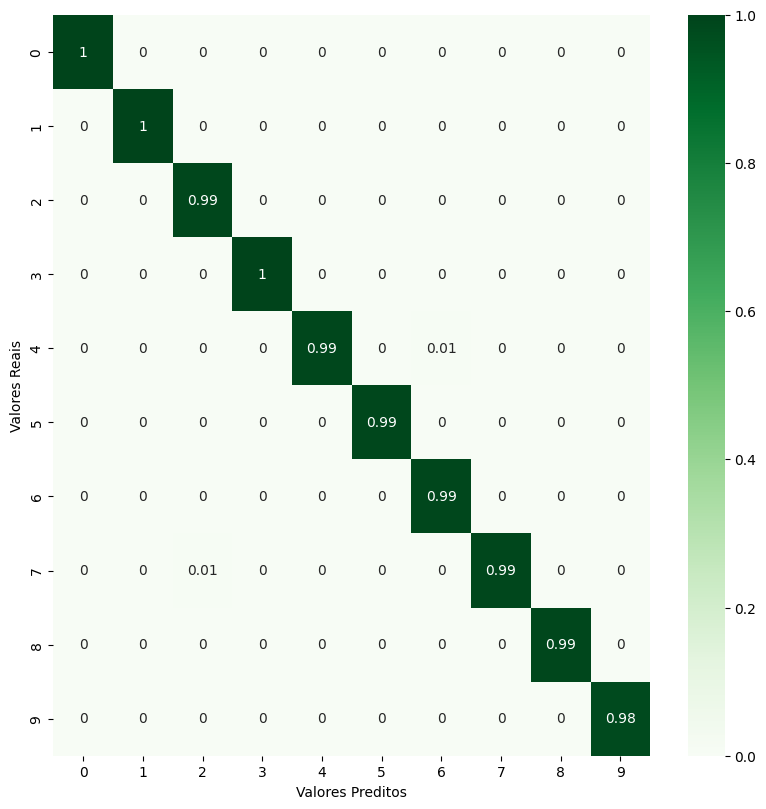

In [35]:
figure = plt.figure(figsize=(8,8))
sns.heatmap(df_matriz_confusao, annot=True, cmap=plt.cm.Greens)
plt.tight_layout()
plt.ylabel('Valores Reais')
plt.xlabel('Valores Preditos')

### Calculando a acurácia, a sensibilidade, a especificibilidade, a precisão e o f-score da matriz de confusão.

In [37]:
acuracia = accuracy_score(labels_teste, y_predito)

In [38]:
precisao = precision_score(labels_teste, y_predito, average='weighted')

In [39]:
sensibilidade = recall_score(labels_teste, y_predito, average='weighted')

In [40]:
matriz_confusao = confusion_matrix(labels_teste, y_predito)
tn = np.diag(matriz_confusao).sum() - matriz_confusao.sum(axis=1)
fp = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao)
especificidade = tn / (tn + fp)

In [41]:
f1 = f1_score(labels_teste, y_predito, average='weighted')

In [43]:
print(f'Acurácia: {acuracia:.2f}')
print(f'Precisão: {precisao:.2f}')
print(f'Sensibilidade: {sensibilidade:.2f}')
print(f'Especificidade: {especificidade.mean():.2f}')
print(f'F1-Score: {f1:.2f}')

Acurácia: 0.99
Precisão: 0.99
Sensibilidade: 0.99
Especificidade: 1.00
F1-Score: 0.99


### Plotando a Curva ROC da matriz de Confusão

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


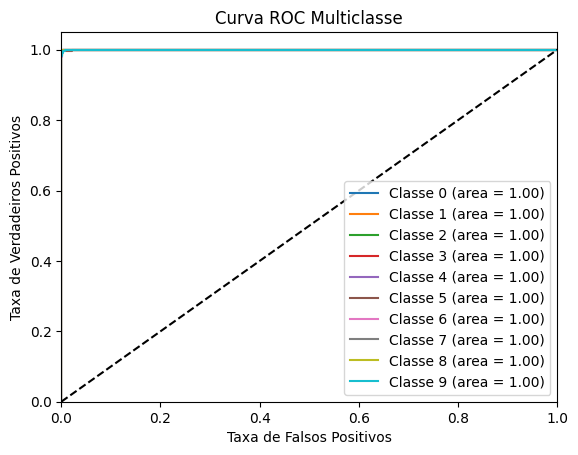

In [42]:
# Binarizando os rótulos para ROC
labels_binarizados = label_binarize(labels_teste, classes=classes)
y_predito_prob = model.predict(imagens_teste)

# Calculando a curva ROC para cada classe
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(labels_binarizados[:, i], y_predito_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotando a curva ROC para cada classe
plt.figure()
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC Multiclasse')
plt.legend(loc="lower right")
plt.show()
